In [1]:
import pandas as pd
import numpy as np
from sodapy import Socrata
from datetime import date
import pickle
import time
from pymongo import MongoClient
from pprint import pprint

In [2]:
db_client = MongoClient()
db_chi=db_client.chicago
lic_history=db_chi.license

In [44]:
from datetime import date


In [7]:
old=business_lic(lic_history)

In [8]:
old.make_dict()
old.lsummary()

1002 1387 Accessory Garage
1003 7560 Commercial Garage
1004 438 Laboratories
1005 973 Long-Term Care Facility
1006 156162 Retail Food Establishment
1007 9379 Wholesale Food Establishment
1008 10877 Hazardous Materials
1009 13176 Manufacturing Establishments
1010 397071 Limited Business License
1011 16895 Home Repair
1012 27097 Home Occupation
1013 352 Body Piercing
1014 824 Retail Computing Center
1016 257 Retail Food Est.-Supplemental License for Dog-Friendly Areas
1020 4159 Residential Real Estate Developer
1023 4809 Children's Services Facility License
1030 126 Navy Pier Vendor (Non-Food)
1032 1958 Animal Care License
1033 29 Navy Pier Vendor (Food)
1034 5 Navy Pier Vendor (Food) 30 Day
1039 140 Bicycle Messenger Service
1046 453 Automatic Amusement Device Operator
1049 64 Public Place of Amusement-TCC
1050 7513 Public Place of Amusement
1052 6 Industrial Private Event Venue
1053 489 Pet Shop
1054 669 Veterinary Hospital
1055 80 Humane Society
1056 407 Performing Arts Venue
1057 12 

In [10]:
old.bsummary()

-1 486347 Unspecified
143 312  Engage in Body Piercing
144 1038 Hair, Nail, and Skin Care Services
197 3060 Tax Preparation Services
228 73 Medical Laboratories
229 30 Diagnostic Imaging Centers
232 225 General Medical and Surgical Hospitals
236 38 Assisted Living Establishment
362 30 Sign Manufacturing
464 247 Provide Home Health Care Services
476 208 Photography Services
599 159 Accounting / Tax Preparation (Home Based Business) 
600 33  Accounting Services (Tax Preparation, Bookkeeping)
601 1912 Acquisition and Improvement of Land/Residential Buildings (Residential Real Estate Developer)
602 6397 Administrative Commercial Office
603 2 Adult Family Care Center (9 to 11 Adults, 55 Years and Older)
606 229 Taxi Affiliation
608 210 Provide Animal Boarding Services
609 318 Animal Care Facility
610 25 Animal Exhibition (30 Days or More)
611 729 Provide Animal Grooming Services
612 126  Provide Animal Training Services
613 31 Artist Work / Live Space
614 20 Beauty Salon, Hair Salon, Nail S

In [131]:

len(old.b_id_dict)

401

In [13]:
df_old=pd.DataFrame(old.lcode_dict).T
df_old.T.sort_index()

,text,count,license_counter
1002,Accessory Garage,1387,"[30.0, 89.0, 90.0, 90.0, 90.0, 85.0, 88.0, 88...."
1003,Commercial Garage,7560,"[75.0, 554.0, 544.0, 546.0, 553.0, 513.0, 525...."
1004,Laboratories,438,"[8.0, 54.0, 51.0, 51.0, 51.0, 52.0, 52.0, 53.0..."
1005,Long-Term Care Facility,973,"[19.0, 113.0, 111.0, 111.0, 111.0, 111.0, 111...."
1006,Retail Food Establishment,156162,"[2204.0, 11100.0, 10791.0, 10940.0, 11069.0, 1..."
...,...,...,...
8342,Food - Shared Kitchen,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8343,Food - Shared Kitchen - Supplemental,266,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8344,Shared Kitchen User,1270,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8345,Shared Kitchen User,117,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [28]:
import matplotlib.pyplot as plt
import geopandas as gpd
#import descartes
#from shapely.geometry import Point,Polygon

In [6]:
'''
Create pipeline for processing licenses.
First process licenses in previous years and obtain historical data
Then process current data.
From current data, select one industry or category, then query historical data for more info.
'''
START_YEAR=2003 #full record keeping starts in 2003, data incomplete before then
MAX_YEARS=25
M_IN_Y=12 #12 month in a year
END_YEAR=START_YEAR+MAX_YEARS-1
LIMIT=20000
SLEEP_TIME=10
#'text':'code description',
#'count':0 #number of license in this code
str_type='application_type'
str_lnum='license_number'

str_issue='date_issued'
str_start='license_start_date'
str_end='expiration_date'
str_lcode='license_code'
str_l_des='license_description'
str_b_id='business_activity_id'
str_bid_des='business_activity'
unknown='UNKNOWN'
BUS_LIC='r5kz-chrr'

def getindex(year,month):
    '''Find index position in counter from text string year and month
    '''
    i_year = int(year)
    if i_year < START_YEAR:
        index=0
    elif i_year > END_YEAR:
        index = MAX_YEARS*M_IN_Y-1
    else:    
        index=(i_year-START_YEAR)*M_IN_Y+int(month)-1
    return index

class business_lic:
    '''Class for handling business license data from 2002
    to present.
    '''
    
    def __init__(self,mongo_collection):
        '''After creating object, either call load() to get previous saved data,
        or pull_hist_lic() to obtain data
        '''        
        self.lcode_dict={}
        #key -1 is used for unspecified business activity
        #i.e. business_activity_id missing in the data
        self.b_id_dict={}
        self.collection=mongo_collection
                    
    #function is slow due to rate limiting from server
    def pull_hist_lic(self,lic_history):
        '''pulling business license history from chicago open data portal.
        to initialize data 
        '''
    #https://data.cityofchicago.org/resource/r5kz-chrr.json
    # Unauthenticated client only works with public data sets. Note 'None'
    # in place of application token, and no username or password:
    # Example authenticated client (needed for non-public datasets):
    # client = Socrata(data.cityofchicago.org,
    #                  MyAppToken,
    #                  userame="user@example.com",
    #                  password="AFakePassword")    
    
        client = Socrata("data.cityofchicago.org", None)   
        date_list = [ for i in range()]
        search_term = str_start + '>' + end_date
        retrived = LIMIT
        db_offset=0    
        while retrived == LIMIT:
            results=client.get(BUS_LIC,limit=LIMIT,order='id', offset=db_offset)
            retrived=len(results)
            db_offset += retrived    
            self.collection.insert_many(results)
            print(f" {db_offset} records have been inserted.")
            time.sleep(SLEEP_TIME)
        cursor=self.collection.find({'city':'CHICAGO'},{'_id':0})         
        make_dict(cursor)
        
#import xmltodict
#import json
#with open('rows.xml') as fd:
#    doc=xmltodict.parse(fd.read())
#    lic_history.insert_many(doc['response']['row']['row'])
    
    def save(self):
        '''save class data into pickle files
        '''
        pickle.dump(self.lcode_dict,open('lic_code.p',"wb"))
        pickle.dump(self.b_id_dict,open("b_id_code.p","wb"))
        
    def load(self):
        '''load class data from pickle files
        '''
        self.lcode_dict=pickle.load(open('lic_code.p','rb'))
        self.b_id_dict=pickle.load(open("b_id_code.p","rb"))

       
    def make_dict(self,cursor):
        '''read from mongoDB to create dictionary containing license counters
        '''
        for i in cursor:
            start_index=0
            if str_start in i:
                start=i[str_start].split('-')
            elif str_issue in i:         #use license issue date instead
                start=i[str_issue].split('-')
                
            start_index=getindex(start[0],start[1])
        
            if str_end in i:
                end=i[str_end].split('-')
                end_index=getindex(end[0],end[1])
            else:
                end_index=start_index
                
            #For renew type license, if starting day is not the first day of month,
            #this month has already been counted by the last month of the previous license. 
            #Start counting this business at next month to avoid duplicate
            if (start[2].split('T')[0] !='1') and (i[str_type]=='RENEW'):
                start_index+=1

            #count the business in every month the license is valid    
            if str_lcode in i:    
                lcode=i[str_lcode]
                if lcode in self.lcode_dict:
                    self.lcode_dict[lcode]['count']+=1            
                else:
                    #create counters
                    if str_l_des in i:
                        text=i[str_l_des]
                    else:
                        text=unknown
                
                    self.lcode_dict[lcode]={'text':text,'count':1,
                               'license_counter':np.zeros((MAX_YEARS*M_IN_Y))}
                self.lcode_dict[lcode]['license_counter'][start_index:end_index+1]+=1


            text='Unspecified'
            if str_b_id in i:
                #Several b_ids may exist in this field.                
                b_ids=i[str_b_id].replace(' ','').split('|')                
            else:
                #missing business_activity_id will be treated as -1 
                b_ids=['-1']
                
            for index, b_id in enumerate(b_ids):
                    if b_id in self.b_id_dict:
                        self.b_id_dict[b_id]['count']+=1
#                       if (b_id_dict[b_id]['text']==unknown) and (str_bid_des in i) and(len(b_ids)==1):
#                           text=i[str_bid_des] 
                    else:
                        #create counters
                
                        #if multiple business activity id, use
                        #text in business activity mstching id.
                        if (str_bid_des in i):
                            text=i[str_bid_des].split('|')[index]                    
                                            
                        self.b_id_dict[b_id]={'text':text,'count':1,
                               'license_counter':np.zeros((MAX_YEARS*M_IN_Y))}
                
                    self.b_id_dict[b_id]['license_counter'][start_index:end_index+1]+=1           
                    
    def find_first(self,lic_number):
        '''Find the earliest license related to this license number.
        '''
        cursor=list(self.collection.find({},{}))

    def lsummary(self):                            
        #create from dict summary table
        total=0
        for i in range(0,9999):
            lcode=str(i)
            if lcode in self.lcode_dict:
                count=self.lcode_dict[lcode]['count']
                print(i, count, self.lcode_dict[lcode]['text'])
                total+=count
        print(total)
        
    def bsummary(self):
        totalb=0
        for i in range(-1,2000):
            b_id=str(i)
            if b_id in self.b_id_dict:
                count = self.b_id_dict[b_id]['count']
                print(i, count, self.b_id_dict[b_id]['text'])
                totalb+=count
        print(totalb)
        
    def update(self):
        '''pull latest and update class data
        '''    
        client = Socrata("data.cityofchicago.org", None)    
        retrived = LIMIT
        db_offset=0
        end_date='2021-07-15'
        search_term=str_start+'>'+end_date
        while retrived == LIMIT:
            results=client.get(BUS_LIC,limit=LIMIT,where=search_term, order='id', offset=db_offset)
            retrived=len(results)
            db_offset += retrived
            make_dict(results)
#            self.collection.insert_many(results)
            print(f" {db_offset} records have been inserted.")
            time.sleep(SLEEP_TIME)
#        save()
         


In [35]:
CUR_BUS_LIC='uupf-x98q'

class active_lic:  
    def __init__(self):
        self.lcode_dict={}
        self.b_id_dict={}        
        
    def pull_curr_lic(self):
        '''pulling active business license from chicago open data portal.
        '''
        #https://data.cityofchicago.org/resource/uupf-x98q.json    
    
        client = Socrata("data.cityofchicago.org", None) 
        results=client.get(CUR_BUS_LIC,limit=LIMIT,order='id',city='CHICAGO')
        retrived=len(results)
        # Convert to pandas DataFrame
        df = pd.DataFrame.from_records(results)
        db_offset=retrived
        while retrived == LIMIT:
            print(f" {db_offset} records have been processed.")
            time.sleep(SLEEP_TIME)
            results=client.get(CUR_BUS_LIC,limit=LIMIT,order='id', offset=db_offset)
            retrived=len(results)
            db_offset += retrived   
            results_df = pd.DataFrame.from_records(results)
            df=pd.concat([df,results_df])                      
        df['earliest']=1    
        self.data=df
        self.refresh_date=date.today()


    def find_lcode(self,lcode,old):
        if lcode not in self.lcode_dict:
            #create entry
            self.lcode_dict[lcode]={'set':False,'data':1}
        elif self.lcode_dict[lcode]['set']:
            # return already found data.
            pass

        #get a list of license number for a particular license code 
        data_list=[ self.data[self.data[str_lcode] == lcode] [str_lnum] ]
        #data_set=set(data_list)
        #search the business_lic data to find earliest license for this user's license number     
        pipeline=[{'$match':{'city':'CHICAGO',str_lcode:lcode }},{'$setIsSubset':['$str_lnum',data_list]} ]
        cursor=list(old.collection.aggregate(pipeline))        
        for i in cursor:
            if i[str_lnum] in data_set:
                self.data[str_lcode == lcode]
            
            i['earliest'] = old.find(i[str_lnum])

id = 'license_number'-'license_start_date'
the same license number may be used by different owner if the 'license_code'  are different
sort by license_code,id should produce same business over a period of time.  

In [ ]:
results_df['license_number']

In [ ]:
results_df1[str_start,str_end]

In [ ]:
lic_history.count_documents({})

In [33]:
new=active_lic()

In [36]:
new.pull_curr_lic()

 {db_offset} records have been processed.
 {db_offset} records have been processed.


In [109]:
lcode=new.data.iloc[0][str_lcode]
data_list= list(new.data[ new.data[str_lcode] == lcode] [str_lnum])
pipeline=[{'$match':{str_lcode:lcode ,'city':'CHICAGO'}}
          ,{'$project':{'license_number':1, 'id':1,'found':{'$setIsSubset':[['$license_number'],data_list]}}} 
          ,{'$match':{'found':True}}]
            

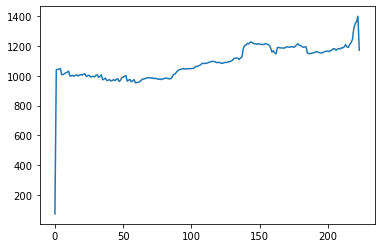

In [110]:
code_count=old.lcode_dict[lcode]['license_counter']
plt.plot(code_count[0:224])
cursor=list(old.collection.aggregate(pipeline))

In [114]:
df_lcode=pd.DataFrame(cursor)
df_lcode['date']=df_lcode['id'].apply(lambda x: str(x).split('-')[1])

In [118]:
dfnew=df_lcode.groupby('license_number').agg({'date':'min'})  

In [129]:
lcode

'1474'

In [126]:
dfnew['date'].value_counts()

20020516    268
20100430     13
20011116     12
20100625      8
20070208      8
           ... 
20140515      1
20171215      1
20070717      1
20080516      1
20140611      1
Name: date, Length: 666, dtype: int64

In [ ]:
#pull_hist_lic(client,lic_history)

#pull_curr_lic(client)

In [ ]:
chi_lic = lic_history.find({'city':'CHICAGO'},{'_id':0})

In [ ]:
pipeline1=[{'$match':{'city':'CHICAGO'}},{'$group':{'_id':{'lcode':'$license_code'}, 
            'count':{'$sum':1}}}, {'$project':{'lcode':1,'count':1}},
          {'$sort':{'_id.lcode':1}}]
pipeline2=[{'$match':{'city':'CHICAGO'}},{'$match':{'ward':'10'}},{'$match':{'$ne': [{'$type':'$precinct'}, 'missing']}},
           {'$project':{'_id':0}},{'$limit':5}]
pipeline3=[{'$match':{'city':'CHICAGO'}},{'$group':{'_id':{'lcode':'$license_code'}, 
            'count':{'$sum':1}}}, {'$project':{'lcode':1,'count':1}},
          {'$sort':{'_id.lcode':1}}]


In [ ]:
#group_data=lic_history.aggregate(pipeline2)
#group_data=lic_history.find({'$and':[{'city':'CHICAGO'},{'precinct':{'$exists':0}}]},{'_id':0})

In [ ]:
group_1=lic_history.find({'$and':[{'city':'CHICAGO'},{str_b_id:'1039'}]},{'_id':0})
a=list(group_1)
a

In [ ]:
group_data=lic_history.find({'city':'CHICAGO'},{'_id':0})

In [ ]:
group_data=lic_history.find({'$and':[{'city':'CHICAGO'},{str_b_id:'855'},{str_end:{'$lt':'2021'}}]},{'_id':0})

In [ ]:
pprint(group_data.next())

In [ ]:
group_data=lic_history.aggregate(pipeline1)
a=list(group_data)
pprint(a)

In [ ]:
lic_history.count_documents({'$and':[{'city':'CHICAGO'},{str_b_id:{'$exists':0}}]})

In [ ]:
lics=lic_history.find({'city':'CHICAGO'},{'_id':0})
b_id_count={}
total,total_b=0,0
for i in lics:
    if str_start not in i:
        continue
    year=i[str_start].split('-')[0]
    if str_b_id in i:
        b_id=1
    else:
        b_id=0
    if year in b_id_count:
        b_id_count[year]['total']+=1
        b_id_count[year]['b_id']+= b_id
    else:
        b_id_count[year]={'total':1,
                         'b_id':b_id}
    total +=1
    total_b += b_id
print(total, total_b)

In [ ]:
b_id_count

In [ ]:
df=pd.DataFrame(lcode_dict)

In [ ]:
df.info()


In [ ]:
df.describe()

In [ ]:
df=[lcode_dict[i]['license_counter'] for i in lcode_dict]
df1=pd.DataFrame(df).T
df_name=[i for i in lcode_dict]
df1.columns=df_name
df=[b_id_dict[i]['license_counter'] for i in b_id_dict]
df2=pd.DataFrame(df).T
df2_name=[i for i in b_id_dict]
df2.columns=df2_name

In [ ]:
totalb=0
for i in range(0,2000):
    b_id=str(i)
    if b_id in b_id_dict:
        count = b_id_dict[b_id]['count']
        print(i, count, b_id_dict[b_id]['text'])
        totalb+=count

In [ ]:
totalb

In [ ]:
df2.describe()


In [ ]:
df1.describe()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge,ElasticNet,Lasso,LassoCV, RidgeCV
#ordinary linear regression + w/ ridge regularization
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm

In [ ]:
lic_count=0
MIN_LIC=40
for i in range(381,399):
    mean= np.mean(df2.iloc[100:240,i])
    if mean >MIN_LIC:
        plt.plot(df2.iloc[10:240,i]/mean,label='{}'.format(i))
        lic_count+=1        
    if lic_count == 6:
        break
plt.legend()        

In [ ]:
df1 [3] suspect  57 after 57, nothing until 71
3 is 2101, valet parking, 57 is 1329 special event food vendor
12 16 started 10 years later
19 started 15 years late
df2 3 suspect  213
3 is 855, valet parking, , 213 is 814, special event food vendor,

no start no end date, all are 1604 1605 lcode, street performer, peddler non-food,
has start no end
b_id 805 shared kicten, non-renewable

In [ ]:
lcode_dict['1329']['text']

In [ ]:
df2_name[213]

In [ ]:
df_name[57]

In [ ]:
df2.shape

In [ ]:
type(df2['1010'])

In [20]:
lic_history.count_documents({'$and':[{'city':'CHICAGO'},{str_issue:{'$exists':0}},{str_start:{'$exists':0}} ]})


0

In [27]:
lic_history.count_documents({'$and':[{'city':'CHICAGO'},{str_start:{'$exists':1}},{str_end:{'$exists':0}} ]})

63

In [15]:
lic_history.count_documents({'$and':[{'city':'CHICAGO'},{str_start:{'$exists':0}}]})

2492

In [ ]:
import pyspark

In [9]:
lic_history.count_documents({'city':'CHICAGO'})

962591

In [16]:
lic_history.count_documents({'$and':[{'city':'CHICAGO'},{str_end:{'$exists':0}}]})

78

In [26]:
a=list(lic_history.find({'$and':[{'city':'CHICAGO'},{str_end:{'$exists':0}},
                                 {str_start:{'$exists':1}}]},{'@_id':0}).limit(5))
pprint(a)       

[{'@_address': 'https://data.cityofchicago.org/resource/r5kz-chrr/row-2tss.jqg4-3rz3',
  '@_position': '0',
  '@_uuid': '00000000-0000-0000-1163-C0DDADFBCB54',
  '_id': ObjectId('60f656dcbefc85a337598297'),
  'account_number': '467654',
  'address': '3657 N MARSHFIELD AVE  APT 1',
  'application_created_date': '2020-04-10T00:00:00',
  'application_requirements_complete': '2020-04-10T00:00:00',
  'application_type': 'ISSUE',
  'business_activity': 'Shared Kitchen User - Short Term (90 Days or Less - '
                       'Not Renewable)',
  'business_activity_id': '805',
  'city': 'CHICAGO',
  'conditional_approval': 'N',
  'date_issued': '2020-11-13T00:00:00',
  'doing_business_as_name': "ROLLIN' N BOWLIN' FRESH FOODS, LLC",
  'id': '2723862-20200413',
  'latitude': '41.948651831',
  'legal_name': "ROLLIN' N BOWLIN' FRESH FOODS, LLC",
  'license_code': '8345',
  'license_description': 'Shared Kitchen User',
  'license_id': '2723862',
  'license_number': '2723862',
  'license_start_d

In [25]:
a=list(lic_history.find({'$and':[{'city':'CHICAGO'},{str_end:{'$exists':1}},
                                 {str_b_id:'805'}]},{'@_id':0}).limit(5))
pprint(a)   

[{'@_address': 'https://data.cityofchicago.org/resource/r5kz-chrr/row-g8nc.2naq.kjtx',
  '@_position': '0',
  '@_uuid': '00000000-0000-0000-E75F-A50DEF2D0703',
  '_id': ObjectId('60f656dcbefc85a3375991a3'),
  'account_number': '429620',
  'address': '9621 S JEFFERY AVE',
  'application_created_date': '2018-11-07T00:00:00',
  'application_requirements_complete': '2018-11-07T00:00:00',
  'application_type': 'ISSUE',
  'business_activity': 'Shared Kitchen User - Short Term (90 Days or Less - '
                       'Not Renewable)',
  'business_activity_id': '805',
  'city': 'CHICAGO',
  'conditional_approval': 'N',
  'date_issued': '2018-11-08T00:00:00',
  'doing_business_as_name': 'BLAQUE BEL CATERING',
  'expiration_date': '2021-02-15T00:00:00',
  'id': '2632057-20181108',
  'latitude': '41.720041126',
  'legal_name': 'TANIA BASTIEN',
  'license_code': '8344',
  'license_description': 'Shared Kitchen User',
  'license_id': '2632057',
  'license_number': '2632057',
  'license_start_dat